In [1]:
# Running All Imports

import numpy as np
from numpy import ndarray
import matplotlib.pyplot as plt
%matplotlib inline

from qiskit import IBMQ, pulse

from qiskit.tools.monitor import job_monitor

from qiskit.visualization.pulse_v2 import stylesheet

from scipy.optimize import curve_fit

from typing import Optional

TOKEN = "a3b55a11da0390b5492acf5a1ccac01e367ccf865802d0a7c5be7af080e3c9f3e8f664c04e57b2f1736eb8f14eefcdd96ca6a13488dc646afac3cedb310dc08f"
IBMQ.save_account(TOKEN, overwrite=True)
# Run previous line with the appropriate token
IBMQ.load_account()

ImportError: cannot import name 'IBMQ' from 'qiskit' (/Users/chatt07/Desktop/new_readout_env/lib/python3.9/site-packages/qiskit/__init__.py)

# Running on Sherbrooke Qubit 0

In [3]:
provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
provider.backends()

### SHERBROOKE DETAILS ###
backend = provider.get_backend('ibm_sherbrooke') # replace the name with the exact one for the backend that is desired from the previous displayed backends
qubit = 0 

In [4]:
DEBUG_PRINT = True

backend_config = backend.configuration()
assert backend_config.open_pulse, "Backend doesn't support Pulse"

dt = backend_config.dt # Example way of getting data on the backend
backend_defaults = backend.defaults() 

acquire_alignment = backend.configuration().timing_constraints['acquire_alignment']
granularity = backend.configuration().timing_constraints['granularity']
pulse_alignment = backend.configuration().timing_constraints['pulse_alignment']

lcm = np.lcm(acquire_alignment, pulse_alignment)

# unit conversion factors -> all backend properties returned in SI (Hz, sec, etc.)
GHz = 1.0e9 # Gigahertz
MHz = 1.0e6 # Megahertz
us = 1.0e-6 # Microseconds
ns = 1.0e-9 # Nanoseconds

# Experiments will be run on these qubits
qubit_0 = 0
qubit_1 = 1

# The sweep will be centered around the estimated qubit frequency.
center_frequency_Hz_0 = backend_defaults.qubit_freq_est[qubit_0]
center_frequency_Hz_1 = backend_defaults.qubit_freq_est[qubit_1]

meas_freq_0 = backend_defaults.meas_freq_est[qubit_0]
meas_freq_1 = backend_defaults.meas_freq_est[qubit_1]

# scale factor to remove factors of 10 from the data
scale_factor = 1e-7

instruction_schedule_map = backend.defaults().instruction_schedule_map
measure_instructions = np.array(instruction_schedule_map.get("measure", qubits=[qubit]).instructions)
measure_pulse = measure_instructions[-2,1].pulse
measure_delay = measure_instructions[-1,1]

x_instructions = np.array(instruction_schedule_map.get("x", qubits=[qubit]).instructions)
x_pulse = x_instructions[0,1].pulse

sx_instructions = np.array(instruction_schedule_map.get("sx", qubits=[qubit]).instructions)
sx_pulse = sx_instructions[0,1].pulse

if DEBUG_PRINT:
    print(f"config: {backend_config}")

    for key, value in backend_config.to_dict().items():
        print(key)
        print(value)
    
    print(f"Sampling time: {dt*1e9} ns")    # The configuration returns dt in seconds, so multiply by
                                            # 1e9 to get nanoseconds

    backend_config.timing_constraints

    print(f"Least common multiple of acquire_alignment and pulse_alignment: {lcm}")

    print(f"Qubit {qubit_0} has an estimated frequency of {center_frequency_Hz_0 / GHz} GHz.")
    print(f"Qubit {qubit_1} has an estimated frequency of {center_frequency_Hz_1 / GHz} GHz.")

    print(f"Resonator for qubit {qubit_0} has an estimated frequency of {meas_freq_0 / GHz} GHz.")
    print(f"Resonator for qubit {qubit_1} has an estimated frequency of {meas_freq_1 / GHz} GHz.")

    print(f"measure_instructions: {measure_instructions}")

    print(f"measurement pulse: {measure_pulse}")
    print(f"measurement delay: {measure_delay}")
    print(f"x pulse: {x_pulse}")
    print(f"sx pulse: {sx_pulse}")

config: <qiskit.providers.models.backendconfiguration.PulseBackendConfiguration object at 0x7fb8cc947370>
backend_name
ibm_sherbrooke
backend_version
1.5.4
n_qubits
127
basis_gates
['id', 'rz', 'sx', 'x', 'ecr', 'reset']
gates
[{'name': 'id', 'parameters': [], 'qasm_def': 'gate id q { U(0, 0, 0) q; }', 'coupling_map': [[0], [1], [2], [3], [4], [5], [6], [7], [8], [9], [10], [11], [12], [13], [14], [15], [16], [17], [18], [19], [20], [21], [22], [23], [24], [25], [26], [27], [28], [29], [30], [31], [32], [33], [34], [35], [36], [37], [38], [39], [40], [41], [42], [43], [44], [45], [46], [47], [48], [49], [50], [51], [52], [53], [54], [55], [56], [57], [58], [59], [60], [61], [62], [63], [64], [65], [66], [67], [68], [69], [70], [71], [72], [73], [74], [75], [76], [77], [78], [79], [80], [81], [82], [83], [84], [85], [86], [87], [88], [89], [90], [91], [92], [93], [94], [95], [96], [97], [98], [99], [100], [101], [102], [103], [104], [105], [106], [107], [108], [109], [110], [111], [112]

## Round Robin Experiments
Consisting of (default 10us rep delay)
1. Default Measurement with 10us, 40us, 90us, 140us, 190us, 240us, 480us delays (Herald-(Meas + Delay) format) with init_qubits=True
2. Default Measurement with 10us, 40us, 90us, 140us, 190us, 240us, 480us delays (Herald-(Meas + Delay) format) with init_qubits=False

In [5]:
meas_delays = np.array([10.0, 40.0, 90.0, 140.0, 190.0, 240.0, 480.0]) * us

28


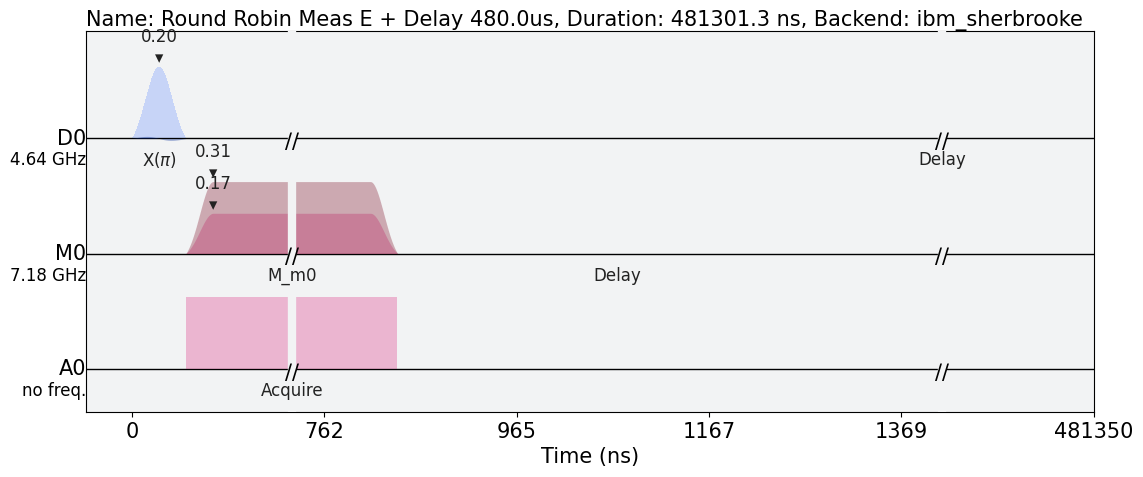

In [6]:
# Make Round-Robin Experiments

from utils import *

round_robin_experiments = []

for m_delay in meas_delays:
    with pulse.build(
        backend=backend,
        default_alignment='sequential',
        name="Round Robin Herald"
    ) as herald_meas:
        qubit_chan = pulse.DriveChannel(qubit)
        
        pulse.measure(
            qubit,
            pulse.MemorySlot(qubit),
        )
    round_robin_experiments.append(herald_meas)

    meas_delay_dt = get_dt_from(m_delay)

    with pulse.build(
        backend=backend,
        default_alignment='sequential',
        name=f"Round Robin Meas G + Delay {m_delay/us}us"
    ) as meas_and_delay_sched_g:
        qubit_chan = pulse.DriveChannel(qubit)
        
        pulse.measure(
            qubit,
            pulse.MemorySlot(qubit),
        )
        pulse.delay(
            meas_delay_dt,
            qubit_chan,
        )
    round_robin_experiments.append(meas_and_delay_sched_g)

    with pulse.build(
        backend=backend,
        default_alignment='sequential',
        name="Round Robin Herald"
    ) as herald_meas:
        qubit_chan = pulse.DriveChannel(qubit)
        
        pulse.measure(
            qubit,
            pulse.MemorySlot(qubit),
        )
    round_robin_experiments.append(herald_meas)

    meas_delay_dt = get_dt_from(m_delay)

    with pulse.build(
        backend=backend,
        default_alignment='sequential',
        name=f"Round Robin Meas E + Delay {m_delay/us}us"
    ) as meas_and_delay_sched_g:
        qubit_chan = pulse.DriveChannel(qubit)
        
        pulse.play(
            x_pulse,
            qubit_chan
        )

        pulse.measure(
            qubit,
            pulse.MemorySlot(qubit),
        )
        pulse.delay(
            meas_delay_dt,
            qubit_chan,
        )
    round_robin_experiments.append(meas_and_delay_sched_g)

print(len(round_robin_experiments))

round_robin_experiments[-1].draw(
    backend=backend,
    style=stylesheet.IQXDebugging(),
    show_framechange=True,
    show_waveform_info=True,
    show_barrier=True,
)

In [7]:
# Verifying Schedules

acquisition_checker(round_robin_experiments, backend)

num_shots = 4096
rep_delay = 10.0 * us
init_qubits = True

In [8]:
# Running total_job

job_experiment = backend.run(round_robin_experiments, 
                            meas_level=1, 
                            meas_return='single', 
                            shots=num_shots,
                            rep_delay=rep_delay,
                            init_qubits=True)

job_monitor(job_experiment)

/Users/chatt07/Desktop/readout_env/lib/python3.9/site-packages/qiskit/compiler/assembler.py:443: RuntimeWarning: Dynamic rep rates are supported on this backend. 'rep_delay' will be used instead of 'rep_time'.
  warnings.warn(


IBMQBackendApiError: "Error submitting job: '400 Client Error: Bad Request for url: https://api-qcon.quantum.ibm.com/api/Network/ibm-q/Groups/open/Projects/main/Jobs. Not defined HTTP error, Error code: 2413.'"

In [ ]:
# Running total_job

job_experiment = backend.run(round_robin_experiments, 
                            meas_level=1, 
                            meas_return='single', 
                            shots=num_shots,
                            rep_delay=rep_delay,
                            init_qubits=False)

job_monitor(job_experiment)